In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os  
import warnings
warnings.filterwarnings('ignore')
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
#The '2' output stream only prints error messages; other miscellaneous information is not printed.

# Data acquisition
Load train, Val and test data

In [3]:
# Load training set data
filepath1 = 'train'
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    filepath1,
    label_mode='categorical',  # "int", "categorical"means onehot, "binary", or None
    seed=123,
    image_size=(128, 128),  # Resize the image to the size we want
    batch_size=64)

# Load validation set data
filepath2 = 'Val'
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    filepath2,
    label_mode='categorical',
    seed=123,
    image_size=(128, 128),
    batch_size=64)

#Load test set data
filepath3 = 'test'
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    filepath3,
    label_mode='int',
    seed=123,
    image_size=(128, 128),
    batch_size=64)

# Class name
class_names = train_ds.class_names
print('Class names：',class_names)
# ['cats', 'dogs', 'panda']

Found 2995 files belonging to 3 classes.
Found 299 files belonging to 3 classes.
Found 297 files belonging to 3 classes.
Class names： ['cats', 'dogs', 'panda']


# Photo processing

img.shape: (64, 128, 128, 3)
label.shape: (64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

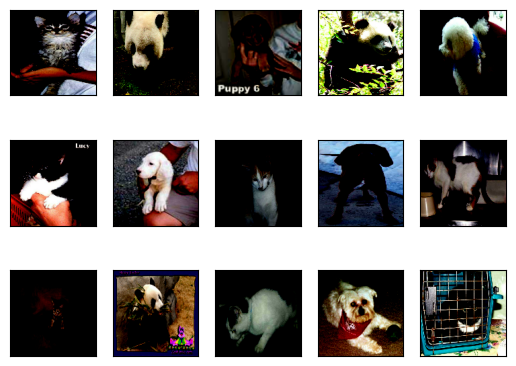

In [4]:
def processing(image, label):
    image = 2 * tf.cast(image, tf.float32) / 255.0 - 1  #between[-1,1]
    label = tf.cast(label, tf.int32) # Modify data type
    return (image, label)

# shuffle
train_ds = train_ds.map(processing).shuffle(10000)  
val_ds = val_ds.map(processing).shuffle(10000)
test_ds = test_ds.map(processing).shuffle(10000)

# Data check
for img, label in train_ds.take(1): 
    print('img.shape:', img.shape)   
    print('label.shape:', label.shape) 

# Show Data set display
import matplotlib.pyplot as plt
for img,label in train_ds.take(1): 
    for i in range(15):
        plt.subplot(3,5,i+1)
        plt.imshow(img[i])  
        plt.xticks([])  
        plt.yticks([])
plt.show()

# Model Build

In [8]:
from tensorflow.keras import layers,optimizers,datasets,Sequential

# ==1== Convolution and pooling layers, 2 convolutions and 1 pooling
network = Sequential()
# unit1
network.add(layers.Conv2D(32, kernel_size=[3,3], strides=1, padding='same', activation=tf.nn.relu))
network.add(layers.Conv2D(32, kernel_size=[3,3], strides=1, padding='same', activation=tf.nn.relu))
network.add(layers.MaxPool2D(pool_size=[2,2], strides=2, padding='same'))
# unit2
network.add(layers.Conv2D(64, kernel_size=[3,3], strides=1, padding='same', activation=tf.nn.relu))
network.add(layers.Conv2D(64, kernel_size=[3,3], strides=1, padding='same', activation=tf.nn.relu))
network.add(layers.MaxPool2D(pool_size=[2,2], strides=2, padding='same'))
# dropout
network.add(layers.Dropout(0.2)) # Each neuron has a probability of 0.2 to be killed

# ==2== Flatten layer, connecting the convolutional pooling layer and the fully connected layer
network.add(layers.Flatten())

# ==3== Fully connected layer
network.add(layers.Dense(128, activation=tf.nn.relu))
network.add(layers.Dense(3))  # Output layer logits layer

# ==4== Specify input layer
network.build(input_shape=[None, 128, 128, 3])

# ==5== View network structure
network.summary()



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                

# Training configuration & Training

In [9]:
# Set dynamic learning rate with exponential decay.
exponential_decay = tf.keras.optimizers.schedules.ExponentialDecay(
                        initial_learning_rate=0.001, #Initial learning rate
                        decay_steps=2,  # Decay step size
                        decay_rate=0.96)  # Decay rate

# Compile
network.compile(optimizer=optimizers.Adam(learning_rate=exponential_decay),
                loss=tf.losses.CategoricalCrossentropy(from_logits=True), # Cross entropy loss
                metrics=['accuracy'])  # Accuracy index

# Early stopping strategy
# When training doesn’t improve anything, stop training
early_stopping = keras.callbacks.EarlyStopping(
    monitor = 'val_accuracy', # The accuracy of the validation set as an indicator
    patience = 5, # The maximum number of cycles that can be tolerated without improvement
    restore_best_weights = True)  # When stopping prematurely, automatically find the optimal monitor parameters.

History = network.fit(train_ds,  # Training set
                    validation_data=val_ds,  # Validation set
                    epochs=35,  # Number of iterations
                    callbacks= early_stopping, # Callback function, called at appropriate times during the training process
                    shuffle = True, # Shuffle before each iteration
                    verbose = 1 # 0: Do not output log information to the standard output stream, 1: Display a progress bar, 2: Output one line of records for each epoch
                    )


Epoch 1/35


47/47 [==============================] - 40s 789ms/step - loss: 1.0124 - accuracy: 0.5078 - val_loss: 0.7330 - val_accuracy: 0.6421
Epoch 2/35
47/47 [==============================] - 39s 801ms/step - loss: 0.6914 - accuracy: 0.6641 - val_loss: 0.6711 - val_accuracy: 0.6622
Epoch 3/35
47/47 [==============================] - 42s 849ms/step - loss: 0.6422 - accuracy: 0.6865 - val_loss: 0.6711 - val_accuracy: 0.6756
Epoch 4/35
47/47 [==============================] - 41s 833ms/step - loss: 0.6111 - accuracy: 0.7068 - val_loss: 0.6384 - val_accuracy: 0.6923
Epoch 5/35
47/47 [==============================] - 40s 825ms/step - loss: 0.6013 - accuracy: 0.7088 - val_loss: 0.6331 - val_accuracy: 0.6890
Epoch 6/35
47/47 [==============================] - 43s 886ms/step - loss: 0.5962 - accuracy: 0.7125 - val_loss: 0.6341 - val_accuracy: 0.6890
Epoch 7/35
47/47 [==============================] - 41s 844ms/step - loss: 0.5967 - accuracy: 0.7132 - val_loss: 0.6327 - val_accuracy: 0.68

In [15]:
network.save("./model")

INFO:tensorflow:Assets written to: ./model\assets


INFO:tensorflow:Assets written to: ./model\assets


# Model evaluation

Text(0.5, 1.0, 'Loss')

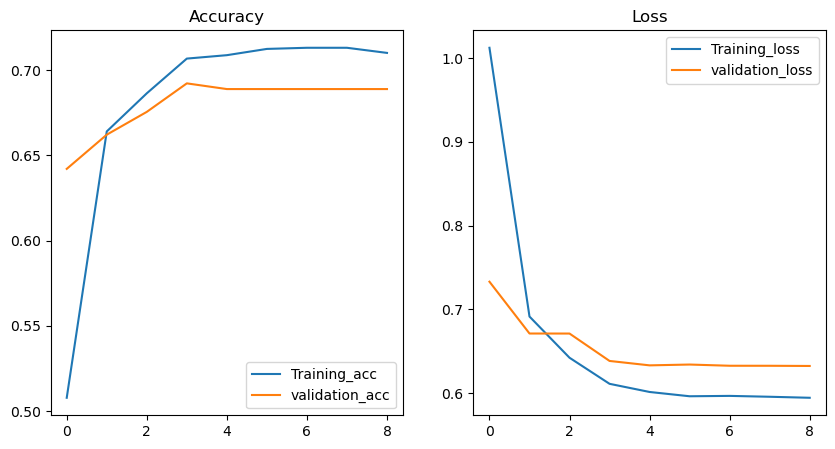

In [10]:
# ==1== Calculate accuracy
train_acc = History.history['accuracy']
val_acc = History.history['val_accuracy']

# ==2== Loss
train_loss = History.history['loss']
val_loss = History.history['val_loss']

# ==3== Graph
epochs_range = range(len(train_acc))  # Abscissa: number of network cycles

# accuracy curve
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, train_acc, label='Training_acc')
plt.plot(epochs_range, val_acc, label='validation_acc')
plt.legend()
plt.title('Accuracy')

# loss curve
plt.subplot(1,2,2)
plt.plot(epochs_range, train_loss, label='Training_loss')
plt.plot(epochs_range, val_loss, label='validation_loss')
plt.legend()
plt.title('Loss')

# Confusion matrix

In [11]:
test_pred = []
test_target = []

for images, targets in test_ds:  #Take a batch test set to generate a confusion matrix

    for image, label in zip(images, targets): # Take out one group from the batch each time
        # Need to add a dimension to the image
        img_array = tf.expand_dims(image, axis=0)
        # Using models to predict animals in pictures
        prediction = network.predict(img_array)
        # The prediction result is the position corresponding to the index of the maximum value of the predicted value
        test_pred.append(class_names[np.argmax(prediction)])
        # Labels that hold the true value
        test_target.append(class_names[label])  
        
print('Train Results:',test_pred[:10])
print('Real Results:',test_target[:10])

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 26ms/step
Train Results: ['dogs', 'panda', 'dogs', 'cats', 'cats', 'dogs', 'dogs', 'panda', 'panda', 'cats']
Real Results: ['dogs', 'panda', 'dogs', 'cats', 'cats', 'panda', 'dogs', 'panda', 'panda', 'cats']


Text(0.5, 47.7222222222222, 'Predictive value')

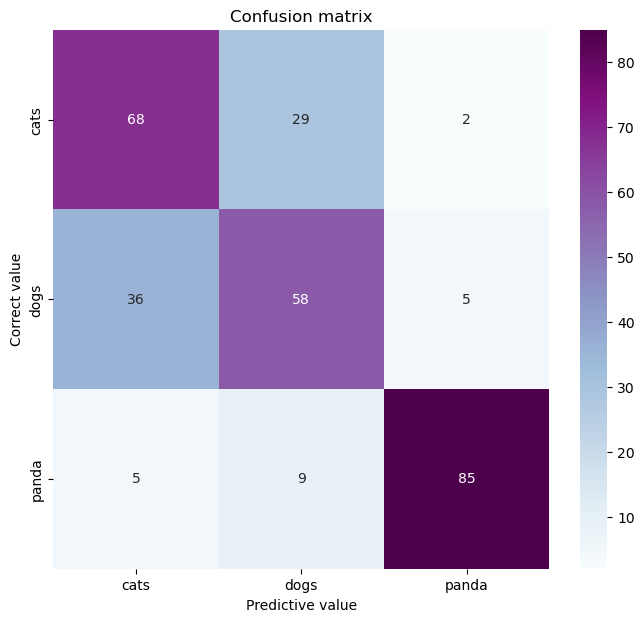

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

# Generate confusion matrix
conf_numpy = confusion_matrix(test_target, test_pred)
# Convert matrix to DataFrame
conf_df = pd.DataFrame(conf_numpy, index=class_names ,columns=class_names)

plt.figure(figsize=(8,7))

sns.heatmap(conf_df, annot=True, fmt="d", cmap="BuPu")

plt.title('Confusion matrix')
plt.ylabel('Correct value')
plt.xlabel('Predictive value')

Prediction for a single image

In [17]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [128, 128])
    image /= 255.0  # normalize to [0,1] range
    return image
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

def softmax(x):
    exp_x = np.exp(x - np.max(x))
    return exp_x / exp_x.sum(axis=1, keepdims=True)

def predict_and_print(image_path):
    # 1. Read image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.resize(image, (128, 128))  # Resize the image to (128, 128)

    # 2. Ensure the shape is (1, 256, 256, 3)
    image = tf.expand_dims(image, axis=0)

    # # 3. Load the pre-trained model
    # model = tf.keras.models.load_model(model_path)

    # 4. Predict
    predictions = network.predict(image)
    print(predictions)


    # 5. Process the prediction result
    # probabilities = (np.exp(predictions) / np.sum(np.exp(predictions), axis=1, keepdims=True)) * 100
    percentages = softmax(predictions) * 100
    print(percentages)

#     # # 使用索引获取子数组
#     subarray = percentages[0]

#     # 获取子数组中的具体元素
#     value_a = subarray[0]
#     value_b = subarray[1]
#     value_c = subarray[2]
#     value_d = subarray[3]

#     plt.imshow(load_and_preprocess_image(image_path))
#     plt.title('Bird classification application')
#     plt.axis("off")

#     # 构建显示的文字内容
#     # 构建显示的文字内容，限制小数点后两位
#     text_content = f"Bananaquit: {round(value_a, 2)}%, Black Skimmer: {round(value_b, 2)}%, " \
#                   f"Black Throated Bushtit: {round(value_c, 2)}%, Cockatoo: {round(value_d, 2)}%"


#     # 在图像下方添加文本
#     plt.text(0.5, -0.1, text_content, ha="center", transform=plt.gca().transAxes)

#     # 显示图像
#     plt.show()
    

# Example usage:
image_path = 'panda1.jpg'
# model_path = 'your_model_path'  # Replace with the path to your saved model
predict_and_print(image_path)


1/1 [==============================] - 0s 25ms/step
[[140.42734 352.30865 -69.77252]]
[[  0. 100.   0.]]
